# Movie Recommendation System

Kevin Nolasco

Cabrini University

MCIS560 - Intro to Machine Learning

03/18/2022

Recommendation systems are one of the greatest innovations that use Machine Learning. Instead of having to spend minutes to hours searching the topics that are relevant to what you are interested in, an algorithm can do the searching for you! For this project we will focus on Movie Recommendations. We will use data taken from [the movies dataset in Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset) and apply 3 recommendation systems. The first method will use a movie's overview and genres to find similar movies to recommend. The second method will use a movie's cast and crew, and the third will use both methods. Below you can see a flow chart that describes the way we will use the data to build the model.

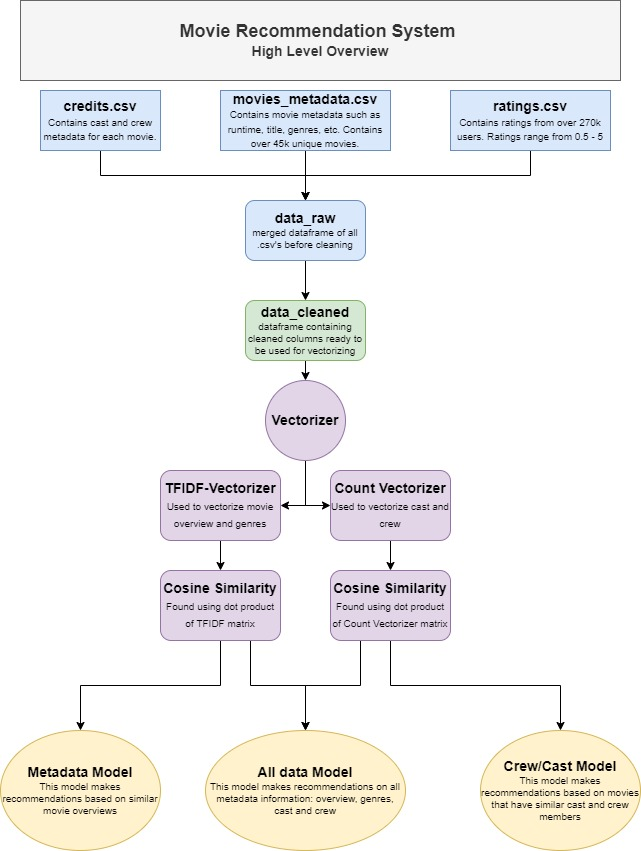

## Import Data

Let's begin by loading the ratings, movie_metadata, and credits .csv files.

In [48]:
import pandas as pd
import os

In [49]:
CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, 'data')
RATINGS_DIR = os.path.join(DATA_DIR, 'ratings.csv')
META_DIR = os.path.join(DATA_DIR, 'movies_metadata.csv')
CREDITS_DIR = os.path.join(DATA_DIR, 'credits.csv')

In [50]:
ratings_df = pd.read_csv(RATINGS_DIR)
movies_metadata_df = pd.read_csv(META_DIR)
credits_df = pd.read_csv(CREDITS_DIR)

C:\Users\nolas\AppData\Local\Temp\ipykernel_3640\1616738804.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata_df = pd.read_csv(META_DIR)


What columns are in our datasets?

In [51]:
dfs = {'ratings' : ratings_df, 'movies_metadata' : movies_metadata_df, 'credits' : credits_df}

for key, value in dfs.items():
    print('====================================\n')
    print('Columns in {}'.format(key))
    print(value.columns)
    print('\n====================================')


Columns in ratings
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


Columns in movies_metadata
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


Columns in credits
Index(['cast', 'crew', 'id'], dtype='object')



Shape of dataframes

In [52]:
dfs = {'ratings' : ratings_df, 'movies_metadata' : movies_metadata_df, 'credits' : credits_df}

for key, value in dfs.items():
    print('====================================\n')
    print('Shape of {}'.format(key))
    print('{:,} rows and {} columns'.format(value.shape[0], value.shape[1]))
    print('\n====================================')


Shape of ratings
26,024,289 rows and 4 columns


Shape of movies_metadata
45,466 rows and 24 columns


Shape of credits
45,476 rows and 3 columns



# EDA

Let's perform a small EDA. First question, on average how many ratings does each user make.

In [53]:
n_users = ratings_df['userId'].nunique()
print('Avg number of ratings per user: {}'.format(int(ratings_df.shape[0] / n_users)))

Avg number of ratings per user: 96


How many users are there?

In [54]:
print('{:,}'.format(ratings_df['userId'].nunique()))

270,896


What is the distribution of ratings among users?

In [55]:
ratings_df.groupby('rating').size()

rating
0.5     404897
1.0     843310
1.5     403607
2.0    1762440
2.5    1255358
3.0    5256722
3.5    3116213
4.0    6998802
4.5    2170441
5.0    3812499
dtype: int64

How many movies are there?

In [56]:
print('{:,}'.format(ratings_df['movieId'].nunique()))

45,115


### Join the datasets

We will join the movies_metadata and credits datasets on the movie ID. Before joining, we need to clean the ID of the movies_metadata dataframe; some of the rows have date-formats instead of an int. We will find those and remove them.

In [57]:
import re
def find_date(id):
    return bool(re.match('^[0-9]+$', id))

In [58]:
movies_metadata_df['keep_row'] = movies_metadata_df['id'].apply(find_date)
movies_metadata_df['keep_row'].value_counts()

True     45463
False        3
Name: keep_row, dtype: int64

Looking at the ID of these rows, we can see they have the format of a date.

In [59]:
movies_metadata_df[movies_metadata_df['keep_row'] == False]['id']

19730    1997-08-20
29503    2012-09-29
35587    2014-01-01
Name: id, dtype: object

In [60]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['keep_row'] == True]
print(movies_metadata_df['keep_row'].value_counts())
movies_metadata_df.loc[: ,'id'] = movies_metadata_df['id'].astype('int64')

True    45463
Name: keep_row, dtype: int64


C:\Users\nolas\AppData\Local\Temp\ipykernel_3640\1411570326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata_df.loc[: ,'id'] = movies_metadata_df['id'].astype('int64')


In [61]:
data_raw = credits_df.merge(movies_metadata_df, on = 'id', how = 'inner').drop_duplicates(subset = ['id'])
data_raw.shape

(45432, 27)

## Recommendation by Rating? Popularity?

Before using ML to create our recommendations, let's see why using the rating of a movie or how many ratings the movie has is not as good.

Let's look at the highest rated movies.

In [62]:
data_raw.sort_values(by = 'vote_average', ascending = False)[['title', 'vote_average', 'vote_count']].head(5)

,title,vote_average,vote_count
37081,Mammal,10.0,1.0
39838,Sunnyside Up,10.0,1.0
24286,Looking for Maria Sanchez,10.0,1.0
21481,Growing Pains,10.0,1.0
34429,Brave Revolutionary,10.0,1.0


Looking at the movies above, they don't look very familiar to me. We can also see that the movies have only been rated one time; this implies that a single person viewed the movie and liked it enough to rate it 10 stars. Does this mean Mammal is a great movie that we should recommend to everyone? Well, no. We should present recommendations based on the type of content the user is enjoying.

For fun, let's see what the top movies are if we only look at how many votes it has.

In [63]:
data_raw.sort_values(by = 'vote_count', ascending = False)[['title', 'vote_average', 'vote_count']].head(5)

,title,vote_average,vote_count
15545,Inception,8.1,14075.0
12525,The Dark Knight,8.3,12269.0
14617,Avatar,7.2,12114.0
17890,The Avengers,7.4,12000.0
26649,Deadpool,7.4,11444.0


These movies are definitely blockbuster movies, we can see that the average score of the movies has increased and that these movies have many votes. Still, would we recommend Inception to someone that is into romantic comedies? Probably not, this is where we will use ML to make recommendations that are relevant to the user.

## Model 1 - Overview and Genres

I would like to build a recommendation system that takes the ratings a user has made, and matches 10 movies that are most similar to the highest rated movies the user rated.
We will use the overview and genres of the movie to define *similarity*.

First, we will extract the genres from the genre column. The information is stored in a string that's in the format of a dictionary.

In [64]:
# clean genres column to be a list of genres seperated by space
import json

def extract_genre(genre):
    """
    use regex to find each dictionary in string,
    convert string to dictionary
    extract name
    return genres as single string
    """
    genre_str = genre.replace('[','').replace(']','').replace('\'', '\"')
    genre_list = []
    # loop through each dict in string using regex
    for small_dict in re.findall('\{.*?\}', genre_str):
        item_dict = json.loads(small_dict)
        genre_list.append(item_dict['name'])
    return ' '.join(genre_list)

In [65]:
data_raw['genres_cleaned'] = data_raw['genres'].apply(extract_genre)
data_raw[['genres_cleaned', 'genres']].iloc[0]

genres_cleaned                              Animation Comedy Family
genres            [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
Name: 0, dtype: object

Now we will add it to the end of the overview, so that we can build a vectorized matrix from a single column.

In [66]:
def append_genres(df):
    return ' '.join([str(df['overview']), str(df['genres_cleaned'])])

In [67]:
# append genre to end of overview
data_raw['overview_final'] = data_raw.apply(append_genres, axis = 1)

In [68]:
data_raw['overview_final'].values[400]

"Starts off in the 15th century, with Connor McLeod (Christopher Lambert) training with another immortal swordsman, the Japanese sorcerer Nakano (Mako). When an evil immortal named Kane (Mario Van Peebles) kills the old wizard, the resulting battle leaves him buried in an underground cave. When Kane resurfaces in the 20th century to create havoc, it's up to McLeod to stop him. Action Fantasy Science Fiction"

### Vectorize

Now we will use Sklearn's TFIDF-Vectorizer on the overview_final column.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# instatiate object and remove stop words

tfidf = TfidfVectorizer(stop_words = 'english')

tfidf_mat = tfidf.fit_transform(data_raw['overview_final'])

Let's look at the shape of this matrix. Rows represent movies, columns represent words that describe the movie

In [70]:
tfidf_mat.shape

(45432, 75827)

Now we can find the cosine similarity score by using the dot product.

In [71]:
from sklearn.metrics.pairwise import cosine_similarity


cos_similarity = cosine_similarity(tfidf_mat, tfidf_mat)

In [72]:
movie_data = data_raw[['title', 'overview_final', 'id']]

The functions below will create the recommendations. We will take the top rated movies for a ranodm user, and see what the model recommends.

In [73]:
def because_you_watched(movies):
    # get 3 top rated movies for a person
    for movie in movies:
        print('===========================================\n')
        print('Because you liked "{}" ... you may enjoy:'.format(movie))
        movie_names = top_5_similar(movie)
        for name in movie_names:
            print(name)
        print('\n===========================================\n')

def top_5_similar(movie):
    # get index of movie
    movie_index = movie_data[movie_data['title'] == movie].index[0]
    # get the row that corresponds to that movie in cosine similarity matrix
    row_of_interest = list(enumerate(cos_similarity[movie_index].reshape(-1)))
    # sort movies
    similar_movies_sorted = sorted(row_of_interest, key = lambda x: x[1], reverse = True)
    # top 5
    the_most_similar = similar_movies_sorted[1:6]
    # return movie names
    return [movie_data.iloc[idx]['title'] for idx, _ in the_most_similar]

In [77]:
user_test = ratings_df[ratings_df['userId'] == 6].merge(data_raw[['id','title']], left_on = 'movieId', right_on = 'id', how = 'inner')
user_favorite_movies = user_test.sort_values(by = 'rating')['title'].iloc[:2].values
user_favorite_movies

array(['Star Wars', 'Joe Versus the Volcano'], dtype=object)

In [78]:
because_you_watched(user_favorite_movies)


Because you liked "Star Wars" ... you may enjoy:
The Empire Strikes Back
The Star Wars Holiday Special
Star Wars: The Force Awakens
Return of the Jedi
Mad Dog Time



Because you liked "Joe Versus the Volcano" ... you may enjoy:
The Wild Parrots of Telegraph Hill
Recep İvedik 4
Homeless in America
Meet Wally Sparks
Shuffle




As we can see, the recommendations for the Star Wars movies are pretty great! I imagine it's because the overviews contain the words "Jedi" and "Space" and others. I am not sure how good the recommendations for the second movie are since I am unfamiliar with "Joe Versus the Volcano".

Let's move onto the second model.

## Model 2 - Cast and Crew

Just like the genres, the cast and crew information is stored in a string with the structure of a dictionary. We will parse through the strings and extract the cast and crew information.

I think it will be useful to differentiate when a person is a director versus an actor. So we will append the title of the person before their name for the crew, but leave the name as is for the cast.

In [79]:
class ClassParser:

    def __init__(self):
        self.issue_counter = 0
        self.cast_counter = 0

    def parse_cast(self, cast_str):
        cast_str = cast_str.replace('[','').replace(']','').replace('\'', '\"')
        cast_list = []
        # loop through each dict in string using regex
        for small_dict in re.findall('\{.*?\}', cast_str):
            try:
                item_dict = json.loads(small_dict)
                cast_list.append(item_dict['name'].replace(' ','').upper())
                self.cast_counter += 1
            except:
                self.issue_counter += 1
        return ' '.join(cast_list)

In [85]:
parser = ClassParser()
data_raw['cast_cleaned'] = data_raw['cast'].apply(parser.parse_cast)
data_raw['cast_cleaned'].iloc[0]

'TOMHANKS TIMALLEN DONRICKLES JIMVARNEY WALLACESHAWN JOHNRATZENBERGER ANNIEPOTTS JOHNMORRIS ERIKVONDETTEN LAURIEMETCALF R.LEEERMEY PENNJILLETTE'

Now let's parse the crew information.

In [83]:
class CrewParser:

    def __init__(self):
        self.issue_counter = 0
        self.crew_counter = 0
        self.crew_counter_simple = 0

    def parse_crew_detailed(self, crew_str):
        crew_str = crew_str.replace('[','').replace(']','').replace('\'', '\"')
        crew_list = []
        # loop through each dict in string using regex
        for small_dict in re.findall('\{.*?\}', crew_str):
            try:
                item_dict = json.loads(small_dict)
            except:
                self.issue_counter += 1
            else:
                crew_list.append('_'.join([item_dict['job'].replace(' ','').lower(), item_dict['name'].replace(' ','').upper()]))
                self.crew_counter += 1
        return ' '.join(crew_list)
    
    def parse_crew_simple(self, crew_str):
        crew_str = crew_str.replace('[','').replace(']','').replace('\'', '\"')
        crew_list = []
        # loop through each dict in string using regex
        for small_dict in re.findall('\{.*?\}', crew_str):
            try:
                item_dict = json.loads(small_dict)
            except:
                self.issue_counter += 1
            else:
                crew_list.append(item_dict['name'].replace(' ','').upper())
                self.crew_counter_simple += 1
        return ' '.join(crew_list)

In [86]:
crew_parser = CrewParser()
data_raw['crew_detailed'] = data_raw['crew'].apply(crew_parser.parse_crew_detailed)
data_raw['crew_detailed'].iloc[0]

'director_JOHNLASSETER screenplay_JOSSWHEDON screenplay_ANDREWSTANTON screenplay_JOELCOHEN screenplay_ALECSOKOLOW executiveproducer_STEVEJOBS editor_LEEUNKRICH artdirection_RALPHEGGLESTON orchestrator_RANDYNEWMAN originalstory_JOHNLASSETER originalstory_PETEDOCTER originalstory_JOERANFT animationdirector_ASHBRANNON music_RANDYNEWMAN songs_RANDYNEWMAN originalstory_ANDREWSTANTON supervisinganimator_PETEDOCTER sounddesigner_GARYRYDSTROM animation_JIMMYHAYWARD animation_BUDLUCKEY animation_JEFFPIDGEON characterdesigner_BUDLUCKEY characterdesigner_ANDREWSTANTON characterdesigner_TOMHOLLOWAY soundre-recordingmixer_GARYRYDSTROM adrvoicecasting_MICKIEMCGOWAN'

In [88]:
data_raw['crew_simple'] = data_raw['crew'].apply(crew_parser.parse_crew_simple)
data_raw['crew_simple'].iloc[0]

'JOHNLASSETER JOSSWHEDON ANDREWSTANTON JOELCOHEN ALECSOKOLOW STEVEJOBS LEEUNKRICH RALPHEGGLESTON RANDYNEWMAN JOHNLASSETER PETEDOCTER JOERANFT ASHBRANNON RANDYNEWMAN RANDYNEWMAN ANDREWSTANTON PETEDOCTER GARYRYDSTROM JIMMYHAYWARD BUDLUCKEY JEFFPIDGEON BUDLUCKEY ANDREWSTANTON TOMHOLLOWAY GARYRYDSTROM MICKIEMCGOWAN'

Now let's add the crew and cast information into a single column.

In [90]:
class AppendMetaData:

    def __init__(self, cols_to_append):
        self.cols_to_append = cols_to_append

    def append_cols(self, df):
        return ' '.join(df[col] for col in self.cols_to_append)

In [93]:
cols_to_append = ['crew_simple', 'crew_detailed', 'cast_cleaned']
append_func = AppendMetaData(cols_to_append)
data_raw['meta_final'] = data_raw.apply(append_func.append_cols, axis = 1)
data_raw['meta_final'].iloc[0]

'JOHNLASSETER JOSSWHEDON ANDREWSTANTON JOELCOHEN ALECSOKOLOW STEVEJOBS LEEUNKRICH RALPHEGGLESTON RANDYNEWMAN JOHNLASSETER PETEDOCTER JOERANFT ASHBRANNON RANDYNEWMAN RANDYNEWMAN ANDREWSTANTON PETEDOCTER GARYRYDSTROM JIMMYHAYWARD BUDLUCKEY JEFFPIDGEON BUDLUCKEY ANDREWSTANTON TOMHOLLOWAY GARYRYDSTROM MICKIEMCGOWAN director_JOHNLASSETER screenplay_JOSSWHEDON screenplay_ANDREWSTANTON screenplay_JOELCOHEN screenplay_ALECSOKOLOW executiveproducer_STEVEJOBS editor_LEEUNKRICH artdirection_RALPHEGGLESTON orchestrator_RANDYNEWMAN originalstory_JOHNLASSETER originalstory_PETEDOCTER originalstory_JOERANFT animationdirector_ASHBRANNON music_RANDYNEWMAN songs_RANDYNEWMAN originalstory_ANDREWSTANTON supervisinganimator_PETEDOCTER sounddesigner_GARYRYDSTROM animation_JIMMYHAYWARD animation_BUDLUCKEY animation_JEFFPIDGEON characterdesigner_BUDLUCKEY characterdesigner_ANDREWSTANTON characterdesigner_TOMHOLLOWAY soundre-recordingmixer_GARYRYDSTROM adrvoicecasting_MICKIEMCGOWAN TOMHANKS TIMALLEN DONRICKLES

Now that the data is clean, let's vectorize the column, and make the cosine similarity matrix to build our recommender.

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(data_raw['meta_final'])

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [96]:
class MovieRecommenderMeta:

    def __init__(self, df, similarity_matrix):
        self.df = df
        self.similarity_matrix = similarity_matrix

    def because_you_watched(self, movies):
        # get 3 top rated movies for a person
        for movie in movies:
            print('===========================================\n')
            print('Because you liked "{}" ... you may enjoy:'.format(movie))
            movie_names = self.top_5_similar(movie)
            for name in movie_names:
                print(name)
            print('\n===========================================\n')

    def top_5_similar(self, movie):
        # get index of movie
        movie_index = self.df[self.df['title'] == movie].index[0]
        # get the row that corresponds to that movie in cosine similarity matrix
        row_of_interest = list(enumerate(self.similarity_matrix[movie_index].reshape(-1)))
        # sort movies
        similar_movies_sorted = sorted(row_of_interest, key = lambda x: x[1], reverse = True)
        # top 5
        the_most_similar = similar_movies_sorted[1:6]
        # return movie names
        return [self.df.iloc[idx]['title'] for idx, _ in the_most_similar]

In [97]:
user_test = ratings_df[ratings_df['userId'] == 6].merge(data_raw[['id','title']], left_on = 'movieId', right_on = 'id', how = 'inner')
user_favorite_movies = user_test.sort_values(by = 'rating')['title'].iloc[:2].values
user_favorite_movies

array(['Star Wars', 'Joe Versus the Volcano'], dtype=object)

In [98]:
recommender = MovieRecommenderMeta(data_raw, cosine_sim2)
recommender.because_you_watched(user_favorite_movies)


Because you liked "Star Wars" ... you may enjoy:
The Empire Strikes Back
Return of the Jedi
Electronic Labyrinth THX 1138 4EB
Empire of Dreams: The Story of the Star Wars Trilogy
Star Wars: Episode III - Revenge of the Sith



Because you liked "Joe Versus the Volcano" ... you may enjoy:
Home of the Brave
Nice Guy Johnny
Newlyweds
Looking for Kitty
The Brothers McMullen




This recommender did a great job as well! Let's put both of the recommenders to work together but taking the sum of the similarity matrices.

## Final Model - All Meta Data from Before

In [101]:
data_cleaned = data_raw[['id','title','overview_final','meta_final']]

In [102]:
data_cleaned.head()

,id,title,overview_final,meta_final
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",JOHNLASSETER JOSSWHEDON ANDREWSTANTON JOELCOHE...
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,JONATHANHENSLEIGH JAMESHORNER JOEJOHNSTON NANC...
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,HOWARDDEUTCH MARKSTEVENJOHNSON MARKSTEVENJOHNS...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",FORESTWHITAKER DEBORAHSCHINDLER KENNETHEDMONDS...
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,ALANSILVESTRI NANCYMEYERS NANCYMEYERS CHARLESS...


In [129]:
## Vectorize and Similarities

# for overview and genre
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_mat = tfidf.fit_transform(data_cleaned['overview_final'])
cos_similarity = cosine_similarity(tfidf_mat, tfidf_mat)

# for cast and crew
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(data_cleaned['meta_final'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

joined_similarity = cosine_sim2 + cos_similarity

MemoryError: Unable to allocate 15.4 GiB for an array with shape (45432, 45432) and data type float64

In [125]:
class MovieRecommender:

    def __init__(self, df, similarity_matrix):
        self.df = df
        self.similarity_matrix = similarity_matrix

    def because_you_watched(self, movies):
        # get 3 top rated movies for a person
        for movie in movies:
            print('===========================================\n')
            print('Because you liked "{}" ... you may enjoy:'.format(movie))
            movie_names = self.top_5_similar(movie)
            for name in movie_names:
                print(name)
            print('\n===========================================\n')

    def top_5_similar(self, movie):
        # get index of movie
        movie_index = self.df[self.df['title'] == movie].index[0]
        # get the row that corresponds to that movie in cosine similarity matrix
        row_of_interest = list(enumerate(self.similarity_matrix[movie_index].reshape(-1)))
        # sort movies
        similar_movies_sorted = sorted(row_of_interest, key = lambda x: x[1], reverse = True)
        # top 5
        the_most_similar = similar_movies_sorted[1:6]
        # return movie names
        return [self.df.iloc[idx]['title'] for idx, _ in the_most_similar]

In [126]:
recommender = MovieRecommender(data_cleaned, joined_similarity)
recommender.because_you_watched(user_favorite_movies)


Because you liked "Star Wars" ... you may enjoy:
The Empire Strikes Back
Return of the Jedi
The Star Wars Holiday Special
Star Wars: The Force Awakens
Empire of Dreams: The Story of the Star Wars Trilogy



Because you liked "Joe Versus the Volcano" ... you may enjoy:
Sidewalks of New York
Nice Guy Johnny
Home of the Brave
The Invitation
Meet Wally Sparks




This the best recommender yet! We can see that all the recommendations for the Star Wars movie is more Star Wars movies. I am still unfamiliar with the movies that are recommended for "Joe Versus the Volcano".

Let's test this recommender against the top 5 most rated movies that we saw earlier.

In [127]:
top_5_rated = data_raw.sort_values(by = 'vote_count', ascending = False)[['title']].head(5).values
top_5_rated = [movie[0] for movie in top_5_rated]
recommender.because_you_watched(top_5_rated)


Because you liked "Inception" ... you may enjoy:
Afstiros katallilo
Finsterworld
Honey and the Pig
The Dolls
A Touch of Spice



Because you liked "The Dark Knight" ... you may enjoy:
Fluke
Magic Hunter
I Really Hate My Job
Little Girls in Pretty Boxes
Fire and Ice: The Dragon Chronicles



Because you liked "Avatar" ... you may enjoy:
Suite 16
Triggermen
Sharpe's Enemy
Waterland
Sharpe's Company



Because you liked "The Avengers" ... you may enjoy:
The NeverEnding Story
The Neverending Story III: Escape from Fantasia
The Flash 2 - Revenge of the Trickster
Momo
Knight Moves



Because you liked "Deadpool" ... you may enjoy:
Triumph of the Will
Education for Death
The Wooden Horse
The Goebbels Experiment
The Spanish Earth




Looks like the model didn't perform as well as I thought. I think the meta_final column may be packed with too much information. Typically people will be fans of directors, producers, music directors, and the top 5 actors. I think including all the crew could be harming the model. I will leave this for an enhancement to make to the next iteration of this project.

Let's see how many films directed by Christopher Nolan are in this dataset.

In [123]:
data_cleaned[data_cleaned['meta_final'].apply(lambda x: 'director_christophernolan' in x.lower())]

,id,title,overview_final,meta_final
2474,11660,Following,"A struggling, unemployed young writer takes to...",CHRISTOPHERNOLAN CHRISTOPHERNOLAN CHRISTOPHERN...
4110,77,Memento,Suffering short-term memory loss after a head ...,CHRISTOPHERNOLAN CHRISTOPHERNOLAN JONATHANNOLA...
5274,320,Insomnia,Two Los Angeles homicide detectives are dispat...,CHRISTOPHERNOLAN WALLYPFISTER MARCILIROFF GEOR...
10158,272,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",HANSZIMMER CHARLESROVEN CHRISTOPHERNOLAN CHRIS...
11399,1124,The Prestige,A mysterious story of two magicians whose inte...,CHRISTOPHERNOLAN CHRISTOPHERNOLAN CHRISTOPHERN...
12525,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,HANSZIMMER CHARLESROVEN CHRISTOPHERNOLAN CHRIS...
15545,27205,Inception,"Cobb, a skilled thief who commits corporate es...",HANSZIMMER CHRISTOPHERNOLAN CHRISTOPHERNOLAN C...
18324,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,HANSZIMMER CHARLESROVEN CHRISTOPHERNOLAN CHRIS...
22950,157336,Interstellar,Interstellar chronicles the adventures of a gr...,LEESMITH CHRISTOPHERNOLAN CHRISTOPHERNOLAN HOY...
25980,43629,Doodlebug,A man is trying to catch some sort of bug runn...,CHRISTOPHERNOLAN CHRISTOPHERNOLAN CHRISTOPHERN...


It looks like the model was not able to recommend any of the Christopher Nolan films for Inception. I will attempt to fix this in the next iteration!

# Conclusion

We can see that even this simple recommendation project was able to parse through 45k movies and recommend 5 that are *similar enough* to the movie that someone likes. There is definitely more work that can be done, but that is the fun part of these types of projets. We will never find the perfect algorithm and all we can do is try to get closer and closer to the results that we are expecting to see. 

Thank you for your time.